In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from enum import Enum
import os

from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import tensorflow as tf
import cv2

from pytesseract import pytesseract
import re
from PIL import Image

from png2spice import POI
from png2spice import parsing

In [2]:
schematicPath = './testSchematicsPNG/schematic3.JPG'
assert os.path.exists(schematicPath)

(158, 4)


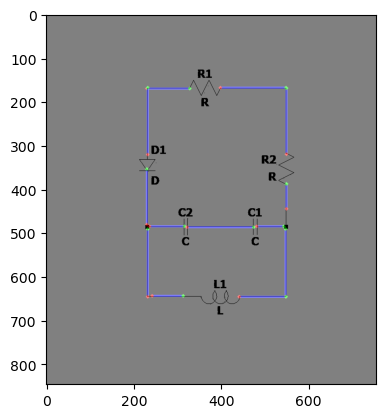

In [6]:
subdirectory_path = "output/randomSubFolder"
if not os.path.exists(subdirectory_path):
    try:
        os.makedirs(subdirectory_path)
    except OSError as e:
        print(f"Error creating subdirectory: {e}")

path = os.path.join(os.getcwd(), subdirectory_path)
filelist = [ f for f in os.listdir(path) if f.endswith(".png") ]
for f in filelist:
    os.remove(os.path.join(path, f))

imagePadding = 70

ret,schematicImage = cv2.threshold(cv2.imread(schematicPath, cv2.IMREAD_GRAYSCALE), 170, 255, cv2.THRESH_BINARY)
schematicImage = cv2.copyMakeBorder(schematicImage,imagePadding,imagePadding,imagePadding,imagePadding,cv2.BORDER_CONSTANT,value=255)

imageSliceSize = 150 # The size of the subimages of POI analysis
HLThreshold = 6 # Hough Lines Transform threshold
HLMinLineLength = 48 # Hough Lines Transform minLineLength
HLmaxLineGap = 2 # Hough Lines Transform maxLineGap
HoughIterations = 10 # Amount of iterations
HoughThresholdWiggle = 17


linesImage = np.zeros((schematicImage.shape+(tuple([3]))), np.uint8)
edges = cv2.Canny(schematicImage, 200, 200, None, 5)
lines = cv2.HoughLinesP(edges, rho = 1, theta = math.pi/2, threshold = HLThreshold, minLineLength = HLMinLineLength , maxLineGap = HLmaxLineGap).squeeze()
for i in range(HoughIterations-1):
    lines = np.append(lines,cv2.HoughLinesP(edges, rho = 1, theta = math.pi/2, threshold = HLThreshold + ((i+1) * HoughThresholdWiggle), minLineLength = HLMinLineLength , maxLineGap = HLmaxLineGap).squeeze(),axis=0)

def saveImageFromPos(img, x, y, winSize, name):
    yMax, xMax = img.shape
    if(x+int(winSize/2) > xMax or y+int(winSize/2) > yMax or x-int(winSize/2) < 0 or y-int(winSize/2) < 0):
        return
    img = img[y-int(winSize/2):y+int(winSize/2), x-int(winSize/2):x+int(winSize/2)]
    filename = subdirectory_path + '/' + str(name) +'.png'
    cv2.imwrite(filename, img)

print(lines.shape)
pointDistance = 50

def similairLineInList(list, line):
    for count, l in enumerate(list):
        pt1 = (l[0],l[1])
        pt2 = (l[2],l[3])
        pt3 = (line[0],line[1])
        pt4 = (line[2],line[3])
        if((math.dist(pt1,pt3) < pointDistance and math.dist(pt2,pt4) < pointDistance) or ((math.dist(pt1,pt4) < pointDistance and math.dist(pt2,pt3) < pointDistance))):
            return True
    return False

prunedLinesList = []
prunedLinesList.append(lines[1].tolist())

for count, line in enumerate(lines):
    if(not similairLineInList(prunedLinesList,line)):
        prunedLinesList.append(line.tolist())

prunedLines = np.asarray(prunedLinesList)

for count, line in enumerate(prunedLines):
    pt1 = (line[0],line[1])
    pt2 = (line[2],line[3])
    cv2.line(linesImage, pt1, pt2, (0,0,255), 4)
    cv2.circle(linesImage, pt1, 2, (255,0,0), 3)
    cv2.circle(linesImage, pt2, 2, (0,255,0), 3)
    saveImageFromPos(schematicImage.copy(), pt1[0],pt1[1], imageSliceSize, str(count) + 'A')
    saveImageFromPos(schematicImage.copy(), pt2[0],pt2[1], imageSliceSize, str(count) + 'B')

#print(prunedLines.shape)

fig, ax = plt.subplots()
im2 = ax.imshow(schematicImage,cmap='gray')
im1 = ax.imshow(linesImage, alpha=0.5)

plt.show()

Found 26 images belonging to 1 classes.
1/1 [==============================] - 3s 3s/step
Found 26 images belonging to 1 classes.


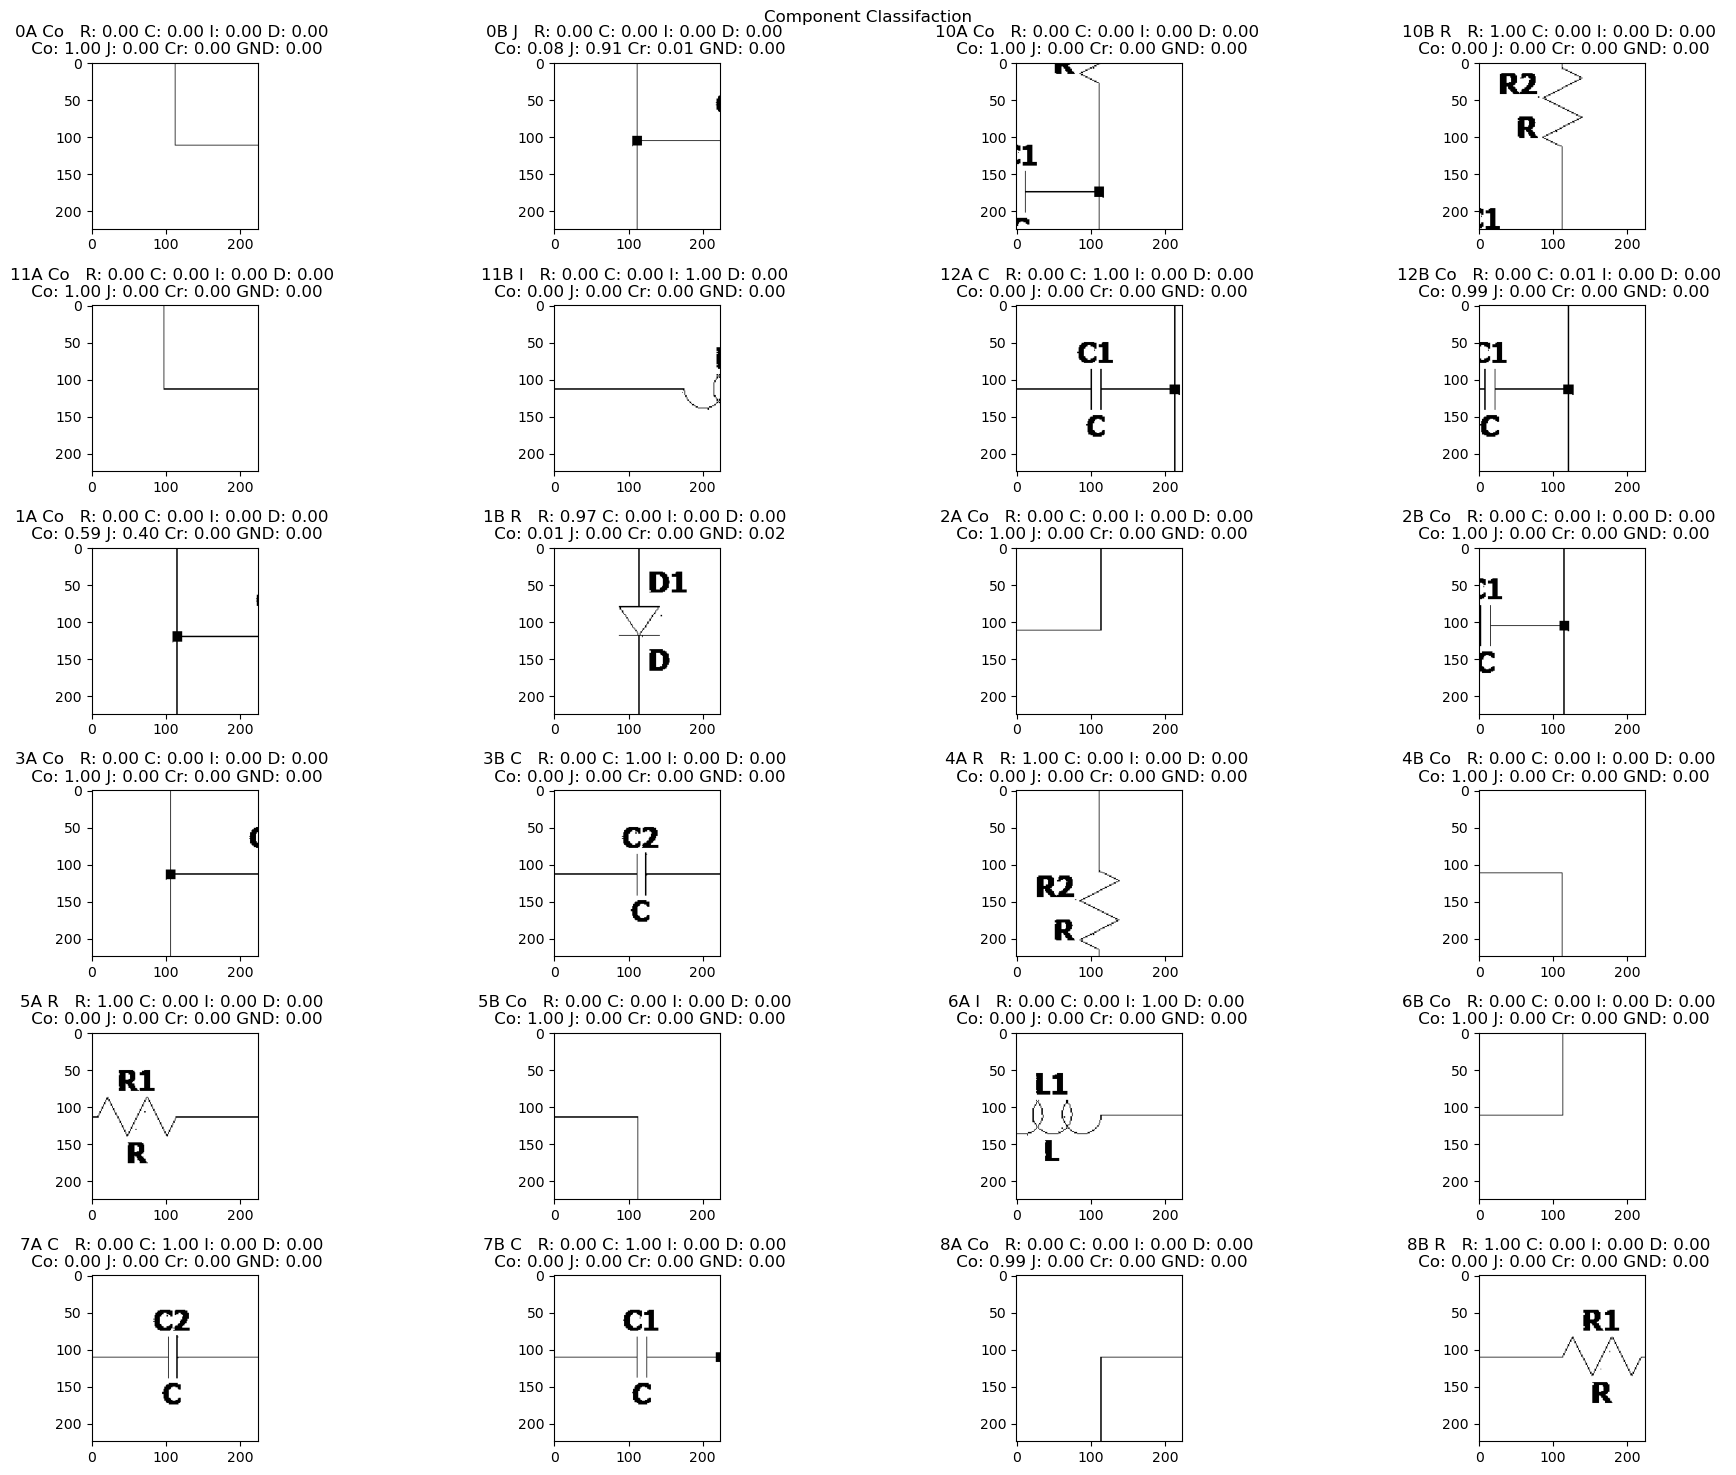

In [7]:
vgg16_model = load_model('./SPICEnet/SPICEnet.h5')

image_resize = 224 #WTF IS THIS???

vgg16_prediction = vgg16_model.predict(
    ImageDataGenerator(
        preprocessing_function=preprocess_input,
        ).flow_from_directory(
            'output',
            #INSERT LAMBDA HERE
            target_size=(image_resize, image_resize),
            shuffle=False)
)

def getType(arr):
    s = np.argmax(arr)
    types = ["R", "C", "I", "D", "Co", "J", "Cr", "GND"]
    return types[s]

my_data_generator = ImageDataGenerator(
    rescale=1./255
)

imageDisplayGenerator = my_data_generator.flow_from_directory(
    'output',
    target_size=(image_resize, image_resize),
    shuffle=False,
    batch_size=100) #THIS IS NE MAX N OF IMAGES TO DISPLAY

fileLabels =  [os.path.basename(s).replace('.png', '') for s in imageDisplayGenerator.filenames]

OCRNameResults = [None] * len(imageDisplayGenerator.filenames)
for count, file in enumerate(imageDisplayGenerator.filenames):
    result = pytesseract.image_to_string(Image.open(os.path.join('output', file)))
    resultPostRegex = re.search(r"[RCDL](\d+)", result, re.IGNORECASE)
    if(resultPostRegex != None):
        OCRNameResults[count] = resultPostRegex.group().capitalize()

batch_images = imageDisplayGenerator.next()[0]

fig, axs = plt.subplots(nrows=int(imageDisplayGenerator.n/4), ncols=4, figsize=(20, 15)) # define your figure and axes
ind = 0
for ax1 in axs:
    for ax2 in ax1:
        ax2.imshow(batch_images[ind])
        ax2.title.set_text(str(fileLabels[ind]) + " " + getType(vgg16_prediction[ind]) + "   R: %.2f C: %.2f I: %.2f D: %.2f \n Co: %.2f J: %.2f Cr: %.2f GND: %.2f" % (vgg16_prediction[ind][0],vgg16_prediction[ind][1],vgg16_prediction[ind][2],vgg16_prediction[ind][3],vgg16_prediction[ind][4],vgg16_prediction[ind][5],vgg16_prediction[ind][6],vgg16_prediction[ind][7]))
        ind += 1

fig.suptitle('Component Classifaction')
plt.tight_layout()
plt.show()

In [10]:
looseGraphLines = prunedLines.copy()
looseGraph = list()
for count, line in enumerate(looseGraphLines):
   if(POI.isValidPOI(vgg16_prediction[fileLabels.index(str(count) + "A")])):
      looseGraph.append(POI.POI(str(count) + "A", line[0:2], POI.pred2Type(vgg16_prediction[fileLabels.index(str(count) + "A")]), OCRNameResults[fileLabels.index(str(count) + "A")]))
   if(POI.isValidPOI(vgg16_prediction[fileLabels.index(str(count) + "B")])):
      looseGraph.append(POI.POI(str(count) + "B", line[2:4], POI.pred2Type(vgg16_prediction[fileLabels.index(str(count) + "B")]), OCRNameResults[fileLabels.index(str(count) + "B")]))

DuplicateVariance = 180
MinDuplicateVariance = 4

#REMOVE DUPLICATES
for count, poi in enumerate(looseGraph):
   for count2, poi2 in enumerate(looseGraph):
      if(math.dist(tuple(poi.position),tuple(poi2.position)) > MinDuplicateVariance and poi != poi2 and math.dist(tuple(poi.position),tuple(poi2.position)) < DuplicateVariance and poi.type == poi2.type):
         del looseGraph[count]

#print([poi.printInfo() for poi in looseGraph])
#print(looseGraphLines)
         
ComponentTerminalAVariance = 30
ComponentTerminalBVariance = 70

#LINK TERMINALS WITH A NEW ATTRIBUTE(terminalALine) TO LINES!
for c, lG in enumerate(looseGraph):
   for count, line in enumerate(looseGraphLines):
      if(math.dist(lG.position, line[0:2]) < ComponentTerminalAVariance):
         lG.terminalALine = line[2:4]
      elif(math.dist(lG.position, line[2:4]) < ComponentTerminalAVariance):
         lG.terminalALine = line[0:2]
      # elif(math.dist(lG.position, line[0:2]) < ComponentTerminalBVariance):
      #    lG.terminalBLine = line[2:4]
      # elif((math.dist(lG.position, line[2:4]) < ComponentTerminalBVariance)):
      #    lG.terminalBLine = line[0:2]

#LINK STUFF UP
for c, lG in enumerate(looseGraph):
   for c2, lG2 in enumerate(looseGraph):
      if(math.dist(lG2.position, lG.terminalALine) < ComponentTerminalAVariance):
         lG.terminalA = lG2
      elif(lG.terminalBLine is not None and (math.dist(lG2.position, lG.terminalBLine) < ComponentTerminalBVariance)):
         lG.terminalB = lG2

#print([poi.terminalBLine for poi in looseGraph])

#PRUNE FLOATING PIECES AKA NOT CONNECTION ON TERMINALS
#looseGraph = [obj for obj in looseGraph if obj.terminalA != None or obj.terminalB != None or obj.terminalC != None or obj.terminalD != None]

# #CRUDE ROTATION ANALYSIS
for c, lG in enumerate(looseGraph):
   #print(lG.type)
   #print(lG.terminalALine)
   #print(lG.terminalBLine)
   #print(abs(lG.terminalALine[1] - lG.terminalBLine[1]))
   if(lG.terminalALine is not None and lG.terminalBLine is not None):
      if(abs(lG.terminalALine[0] - lG.terminalBLine[0]) < 40):
         print(abs(lG.terminalALine[0] - lG.terminalBLine[0]))
         lG.rotation = 0
      else: #if(abs(lG.terminalALine[1] - lG.terminalBLine[1]) < 40):
         lG.rotation = 90 # COMPENTS LAY
   else:
      print("PART IS NOT TWICE ATTACHEED")
      print(lG.printInfo())

#VISUALIZATION FOR EVAL PURPOSES
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 1
fontColor              = (255,0,0)
thickness              = 2
lineType               = 2

evalImage = np.zeros((schematicImage.shape+(tuple([3]))), np.uint8)
for c, lG in enumerate(looseGraph):
   cv2.putText(evalImage,str(POI.POITypes.get_index(lG.type)), lG.position, font, fontScale,fontColor,thickness,lineType)

fig, ax = plt.subplots()
im1 = ax.imshow(evalImage)

plt.show()

#[poi.printInfo() for poi in looseGraph]
#looseGraph[0].terminalA

IndexError: list assignment index out of range

In [ ]:

parser = parsing.CParser(looseGraph)
output_path = "./output.asc"

#for p in looseGraph:
    #print(p.terminalALine[0])

dir = os.listdir(os.getcwd())
if(output_path in dir):
    os.remove(os.path.join(os.getcwd(), output_path))

parser.Graph2Asc(output_path)